## 策略定义

现在已经学会了如何访问和操作Quantopian中的数据，让我们为多头空头股票策略构建数据pipeline。一般而言，多头空头股票策略包括资产相对价值，并对我们有信心的资产组合增加下注(多头)和减少下注(空头)。

随着高价值和低价值资产集合之间的收益差距的增加，多头空头股票策略将获利。多头空头股票策略的质量完全依赖于其底层排名模型的质量。 在本教程中，我们将为我们的战略使用一个简单的排名模式：

**策略**：我们将考虑尾部12个月每股股利平均值/股价作为基本指标，评分高的资产作为高价值，评分低的资产评分为低价值。

## 策略分析

In [1]:
import warnings

In [2]:
warnings.filterwarnings('ignore')

我们可以使用`builtin`模块中的自定义函数`trailing_dividend_yield`来定义上面的策略，类似于我们在上一课中创建的管道：

为了简单起见，我们只分析根据`trailing_dividend_yield`排名的前350名和后350只股票。我们可以使用`trailing_dividend_yield`输出的顶`top`和`bottom`方法为这些集合创建`pipeline`过滤器，并使用`|`运算符联合。然后，将使用`&`运算符来获得过滤器和总体之间的交集，从而移除可交易的总体之外的任何东西：

In [3]:
# Import Pipeline class and datasets
from zipline.pipeline import Pipeline
# Import built-in trading universe
from zipline.pipeline.builtin import QTradableStocksUS, trailing_dividend_yield

# Pipeline definition
def  make_pipeline():

    base_universe = QTradableStocksUS()

    # 尾部12个月每股股利平均值/股价
    tdy = trailing_dividend_yield()

    # Create filter for top 350 and bottom 350
    # assets based on their sentiment scores
    top_bottom_scores = (
        tdy.top(350) | tdy.bottom(350)
    )

    return Pipeline(
        columns={
            'tdy': tdy,
        },
        # Set screen as the intersection between our filter
        # and trading universe
        screen=(
            base_universe
            & top_bottom_scores
        )
    )

接下来，运行3年的`pipeline`，以获得可用于分析的输出。这将需要约15秒。

In [4]:
# Import run_pipeline method
from zipline.research import run_pipeline

# Specify a time range to evaluate
period_start = '2015-01-01'
period_end = '2018-05-18'

# Execute pipeline over evaluation period
pipeline_output = run_pipeline(
    make_pipeline(),
    period_start,
    period_end
)

除了上述数据外，我们还需要此期间所有股票的价格数据。我们可以很容易地从管道输出的索引中获得这些资产的清单，并将该清单传递给`prices`函数以获取我们需要的数据：

In [5]:
# Import prices function
from zipline.research import prices

# Get list of unique assets from the pipeline output
asset_list = pipeline_output.index.levels[1].unique()

# Query pricing data for all assets present during
# evaluation period
asset_prices = prices(
    asset_list,
    start=period_start,
    end=period_end
)

[2018-05-21 11:51:21.506031] INFO: zipline.finance.metrics.tracker: Simulated 1 trading days
first open: 2018-05-18 01:31:00+00:00
last close: 2018-05-18 07:00:00+00:00


In [6]:
asset_prices.tail()

,平安银行(000001),万 科Ａ(000002),国农科技(000004),世纪星源(000005),深振业Ａ(000006),神州高铁(000008),美丽生态(000010),深物业A(000011),南 玻Ａ(000012),沙河股份(000014),...,新华网(603888),新澳股份(603889),晨光文具(603899),益丰药房(603939),哈森股份(603958),银龙股份(603969),国泰集团(603977),艾华集团(603989),洛阳钼业(603993),中新科技(603996)
2018-05-14 00:00:00+00:00,11.18,27.94,21.45,3.75,7.31,5.60,3.70,14.88,7.24,14.25,...,22.03,12.93,29.90,60.02,14.24,8.360,10.051,36.99,8.29,17.22
2018-05-15 00:00:00+00:00,11.12,27.75,21.43,3.72,7.43,5.78,3.73,15.06,7.26,14.41,...,22.05,13.03,31.13,60.02,14.44,8.450,10.214,36.90,8.33,18.46
2018-05-16 00:00:00+00:00,10.90,27.23,22.09,3.70,7.44,5.91,3.92,14.91,7.14,14.10,...,21.51,13.02,31.04,60.02,14.38,8.340,10.170,36.85,8.18,19.04
2018-05-17 00:00:00+00:00,10.82,26.79,21.59,3.68,7.51,5.93,3.92,15.05,7.15,14.37,...,21.52,12.99,31.26,60.02,14.47,8.189,9.970,36.19,8.10,18.98
2018-05-18 00:00:00+00:00,10.96,27.15,21.60,3.68,7.51,6.31,3.98,15.06,7.22,14.21,...,21.59,13.05,31.56,60.02,15.01,8.280,9.970,36.38,8.20,19.10


现在可以使用开源因子分析工具`Alphalens`来测试选择策略的质量。首先，使用`get_clean_factor_and_forward_returns`来联合因子和股价数据。该函数将我们的因子数据分类为分位数，并计算多个持有期的每种证券的远期回报。将因子数据分成两个分位数（上下半部分），并使用1，5分位数和10天的持有期间：

In [7]:
# Import Alphalens
import alphalens as al

# Get asset forward returns and quantile classification
# based on sentiment scores
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=pipeline_output['tdy'],
    prices=asset_prices,
    quantiles=2,
    periods=(1,5,10),
)

# Display first 5 rows
factor_data.head(5)

从因子数据中舍弃了1.4%的条目：其中远期收益率计算为1.4%分箱阶段为0.0%(设置`max_loss=0`查看潜在抑制的异常
max_loss为35.0%，未超出: OK!


1D        5D       10D  \
date                      asset                                        
2015-01-05 00:00:00+00:00 深物业A(000011) -0.034683 -0.102014 -0.161412   
                          深中华A(000017)  0.012894  0.101719  0.050143   
                          深深宝Ａ(000019)  0.016645 -0.014085  0.005122   
                          深深房Ａ(000029) -0.024162 -0.103984 -0.173738   
                          神州数码(000034)  0.010222 -0.072868 -0.096232   

                                          factor  factor_quantile  
date                      asset                                    
2015-01-05 00:00:00+00:00 深物业A(000011)  0.001122                1  
                          深中华A(000017)  0.000000                1  
                          深深宝Ａ(000019)  0.026008                2  
                          深深房Ａ(000029)  0.029112                2  
                          神州数码(000034)  0.000000                1

利用这种格式的数据，我们可以使用`Alphalens`的几种分析和绘图工具。首先，看一下分位数在整个时期的平均收益率。我们的目标是建立一个多空策略，我们希望看到较低的分位数（1）具有负回报，而较高的分位数（2）具有正回报：

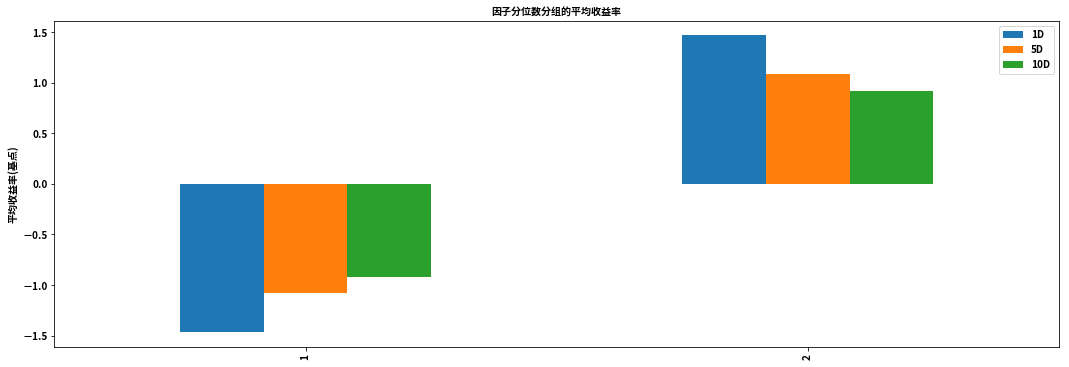

In [8]:
# Calculate mean return by factor quantile
mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(factor_data)

# Plot mean returns by quantile and holding period
# over evaluation time range
al.plotting.plot_quantile_returns_bar(
    mean_return_by_q.apply(
        al.utils.rate_of_return,
        axis=0,
        args=('1D',)
    )
);

还可以使用以下代码绘制5天持有期的多因素加权多空投资组合的累积收益率：

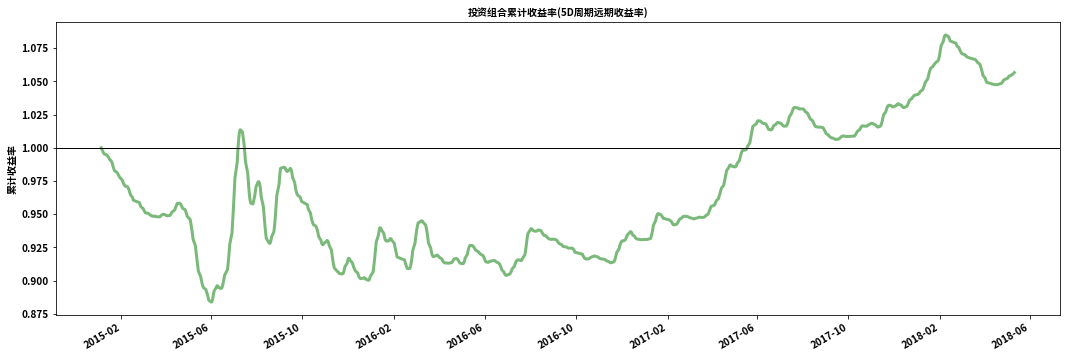

In [9]:
# Calculate factor-weighted long-short portfolio returns
ls_factor_returns = al.performance.factor_returns(factor_data)

# Plot cumulative returns for 5 day holding period
al.plotting.plot_cumulative_returns(ls_factor_returns['5D'], '5D');

上面的图表显示了一个大的回撤期，而这种分析尚未考虑交易成本或市场影响。 这不是一个非常有前景的策略。 在这一点上，我们真的应该使用Alphalens进行更深入的分析，然后重复迭代我们的策略构想。但为了本教程的缘故，让我们按照原样继续我们的策略。
定义并测试了一个策略之后，让我们用它来构建和测试一个多头空头股票算法。教程的其余部分将涵盖算法API，并将在交互式开发环境（IDE）中进行。